<a href="https://colab.research.google.com/github/salim-hbk/ai-ml/blob/main/CustomTrainig_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

In [116]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(DATASET_URL, names=col_names)
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


(array([458.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 241.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <a list of 20 Patch objects>)

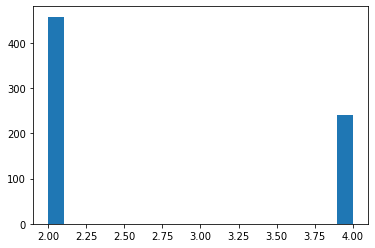

In [117]:
plt.hist(df['class'], bins=20)

In [118]:
df.pop("id")
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

In [119]:
df['class'] = np.where(df['class']==2, 0, 1)
df.head()

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [120]:
train, test = train_test_split(df, test_size=0.2)

In [121]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

In [122]:
train_y = train.pop('class')
test_y = test.pop('class')

In [123]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

In [124]:
train_x = norm(train)
test_x = norm(test)

In [125]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_x.values, test_y.values))

In [126]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)
test_dataset  = test_dataset.shuffle(buffer_size=len(test)).batch(batch_size) 

In [127]:
a = enumerate(train_dataset)
len(list(a))

18

In [128]:
def base_model():
  input = tf.keras.layers.Input(shape=(len(train.columns)))
  x = tf.keras.layers.Dense(128, activation='relu')(input)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model
model = base_model()

In [129]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

Evaluating un trained model

In [139]:
hist = model(test_x.values)
hist = tf.reshape(hist, [-1])
loss_value = loss_object(test_y.values, hist)
print('Loss before traininf %.4f'% loss_value.numpy())

Loss before traininf 0.7347


In [131]:
from sklearn.metrics import confusion_matrix

In [132]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
  cm = confusion_matrix(y_true, y_pred)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title(title)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "white")
  plt.show()

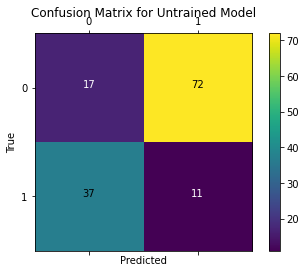

In [133]:
plot_confusion_matrix(test_y.values, tf.round(hist), title='Confusion Matrix for Untrained Model')

# Define Custom F1Score Metric
precision  = TP/TP+FP
recall = TP/TP+FN

F1_score = 2(precision*recall)/precision+recall

We use confusion_matrix defined in tf.math to calculate precision and recall.

Here you can see that we have subclassed tf.keras.Metric and implemented the three required methods update_state, result and reset_states.


In [155]:
class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='f1_score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)

    self.tp = tf.Variable(0, dtype='int32')
    self.tn = tf.Variable(0, dtype='int32')

    self.fp = tf.Variable(0, dtype='int32')
    self.fn = tf.Variable(0, dtype='int32')

  def update_state(self, y_true, y_pred, sample_weight=None):
    conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
    self.tn.assign_add(conf_matrix[0][0])
    self.tp.assign_add(conf_matrix[1][1])
    self.fp.assign_add(conf_matrix[0][1])
    self.fn.assign_add(conf_matrix[1][0])

  def result(self):
    # Calculate precision
    if (self.tp + self.fp == 0):
        precision = 1.0
    else:
        precision = self.tp / (self.tp + self.fp)

    # Calculate recall
    if (self.tp + self.fn == 0):
      recall = 1.0
    else:
      recall = self.tp / (self.tp + self.fn)

    f1_score = 2 * ((precision * recall) / (precision + recall))

    return f1_score

  def reset_states(self):
    self.tp.assign(0)
    self.tn.assign(0) 
    self.fp.assign(0)
    self.fn.assign(0)

    

In [156]:
test_F1Score  = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()

<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

In [157]:
train_f1score_metric = F1Score()
val_f1score_metric   = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

The core of training is using the model to calculate the logits on specific set of inputs and compute the loss(in this case binary crossentropy) by comparing the predicted outputs to the true outputs. We then update the trainable weights using the optimizer algorithm chosen. The optimizer algorithm requires our computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

We use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [158]:
def apply_gradients(x, y_true):
  with tf.GradientTape() as t:
    logits = model(x)
    train_loss = loss_object(y_true, logits)

  gradient = t.gradient(train_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradient, model.trainable_weights))

  return logits, train_loss


This function performs training during one epoch. We run through all batches of training data in each epoch to make updates to trainable weights using our previous function. You can see that we also call update_state on our metrics to accumulate the value of our metrics.

We are displaying a progress bar to indicate completion of training in each epoch. Here we use tqdm for displaying the progress bar.

In [164]:
def train_one_epoch(datasets, optimizer, loss_object, model, train_acc_metric, train_f1score_metric, verbose=True):
  losses = []
  for batch, (train_x, train_y) in enumerate(datasets):
    logits, loss_value = apply_gradients(train_x, train_y)
    losses.append(loss_value)

    logits = tf.round(logits)
    logits = tf.cast(logits, 'int64')

    train_acc_metric.update_state(train_y, logits)
    train_f1score_metric.update_state(train_y, logits)

    if verbose:
      print("Training loss for step %s: %.4f" % (int(batch), float(loss_value)))

  return losses

In [165]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

Next we define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here we combine the functions we built earlier to establish the following flow:

Perform training over all batches of training data.

1) Get values of metrics.

2) Perform validation to calculate loss and update validation metrics on test data.

3) Reset the metrics at the end of epoch.

4) Display statistics at the end of each epoch.

Note : We also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [166]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
  print('start of epoch %d'%(epoch))

  loss_train = train_one_epoch(train_dataset, optimizer, loss_obj, model, train_acc_metric, train_f1score_metric, True)

  train_acc = train_acc_metric.result()
  train_f1score = train_f1score_metric.result()

  #Perform validation on all batches of test data
  losses_val = perform_validation()

  val_acc = val_acc_metric.result()
  val_f1score = val_f1score_metric.result()

  losses_train_mean = np.mean(loss_train)
  losses_val_mean = np.mean(losses_val)

  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

  train_acc_metric.reset_states()
  train_f1score_metric.reset_states()

  val_acc_metric.reset_states()
  val_f1score_metric.reset_states()

start of epoch 0
Training loss for step 0: 0.1491
Training loss for step 1: 0.1613
Training loss for step 2: 0.1462
Training loss for step 3: 0.1298
Training loss for step 4: 0.1098
Training loss for step 5: 0.0804
Training loss for step 6: 0.0885
Training loss for step 7: 0.1353
Training loss for step 8: 0.1262
Training loss for step 9: 0.2237
Training loss for step 10: 0.0843
Training loss for step 11: 0.0691
Training loss for step 12: 0.0542
Training loss for step 13: 0.1400
Training loss for step 14: 0.2713
Training loss for step 15: 0.2338
Training loss for step 16: 0.0651
Training loss for step 17: 0.0971

 Epcoh 0: Train loss: 0.1314  Validation Loss: 0.1112, Train Accuracy: 0.9722, Validation Accuracy 0.9590, Train F1 Score: 0.9588, Validation F1 Score: 0.9592
start of epoch 1
Training loss for step 0: 0.0410
Training loss for step 1: 0.0406
Training loss for step 2: 0.1280
Training loss for step 3: 0.2711
Training loss for step 4: 0.0866
Training loss for step 5: 0.0748
Traini

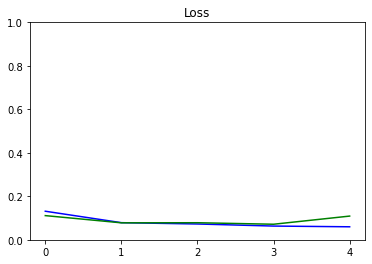

In [167]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

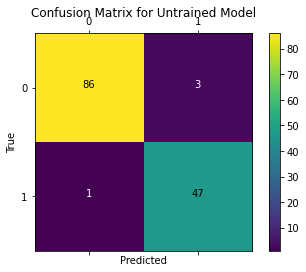

In [170]:
test_outputs = model(test_x.values)
plot_confusion_matrix(test_y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')